# Film Script Analyzer

## Classification

The task for the machine learning models is generalization, that is, to be able to correctly tell things about stuff it has never seen before. To do so, it needs to see some stuff before to learn the patterns that lay underneath the surface of data.

The first thing the model will do is learn to correctly classify a script into a genre.

In [2]:
import pandas as pd 

df = pd.read_csv('data/dfreps0.csv',index_col=0)

Some genres appear only on a few ocasions, there are methods to deal with these situations, however right now this scripts will be left out of the classification. The genres kept will be those that appear at least 14 times or more in the dataset.

In [4]:
n = 14

keep1 = pd.Series(df['Genre1'].value_counts()>=n)
keep1 = set(pd.Series(df['Genre1'].value_counts()>=n).index[keep1==True])

keep2 = pd.Series(df['Genre2'].value_counts()>=n)
keep2 = set(pd.Series(df['Genre2'].value_counts()>=n).index[keep2==True])

keep  = keep1 & keep2

Create the training and target sets. This is done by removing the rows not wanted and selecting either Genre1 or Genre2 as target values.

In [9]:
index = []

for i, j in zip(df['Genre1'],df['Genre2']):
    if i in keep or j in keep:
        index.append(True)
    else:
        index.append(False)
        
train   = df[df.columns[:44]].ix[index]
target1 = df['Genre1'].ix[index]
target2 = df['Genre2'].ix[index]

Try various learning algorithms to check their performance, literature has high steem for SVM on NLP tasks, start with that one.

Grid search is used to check combinations of tuning parameters that yield the best performance based on the score method defined, accuracy.

The search is done with crossvalidation, a technique where one part of the data is separated to be the training set and another part to be the test set, so it gives an estimation of the performance with unseen data and prevents overfitting.

In [10]:
from sklearn.svm             import SVC
from sklearn.metrics         import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf','linear','sigmoid'],'gamma':[0.001,0.005,0.01],'C':[10.,15.,20.]}
clf        = SVC()
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

/Users/luiscastro/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.521819366044
{'kernel': 'rbf', 'C': 15.0, 'gamma': 0.005}


That means that aproximately 52% of the genres where correctly assessed, good but not great; try Random Forest.

In [12]:
from sklearn.ensemble import RandomForestClassifier as RFC

parameters = {'n_estimators':[250,300,350],'max_depth':[12,13,14]}
clf        = RFC(random_state=0)
acc_scorer = make_scorer(accuracy_score,greater_is_better=True)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target1)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

0.468844984802
{'n_estimators': 300, 'max_depth': 13}


Around 47% of the classifications where done correctly by RF.

Those numbers are still too low, see if can be done better, by using feature selection. Feature selection chooses the features that have the highest predicting power and leave behind those withou contribution or that may cause noise.

Two differente methods for feature selection are used to check which gives the best performance and if possible, with the lowest number of used features. Simpler faster models.

Two functions will be defined for this task, **'splitter'** that will divide the data for crossvalidation, and **'subsetc'** that will evaluate the models with different choices of k features.

Will evaluate with both SVC and RFC.

In [13]:
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, SelectKBest
import numpy                   as np

def splitter(x,splits,n=0):
    L     = len(x)
    split = int(L/splits)
    test  = range(n*split,(n+1)*split)
    train = range(0,test[0])+range(test[-1]+1,L)
    return train, test

def subsetc(model,train,target,n=3):
    side = train.shape[1]
    predictions = pd.DataFrame(data=np.zeros(shape=(side,2)),
                               columns=['f_class','m_i_class'],
                               index=range(1,side+1))

    for i in range(side,0,-1):
        clf_f = SelectKBest(f_classif,k=i)
        clf_f.fit(train,target)
        c_l   = list(train.columns[clf_f.get_support(True)])
        df_f  = clf_f.transform(train)

        clf_m = SelectKBest(mutual_info_classif,k=i)
        clf_m.fit(train,target)
        c_m   = list(train.columns[clf_m.get_support(True)])
        df_m  = clf_m.transform(train)

        for j in range(n):
            train_index, test_index         = splitter(target,n,j)
            
            clf                             = model
            clf.fit(df_f[train_index],target[train_index])
            pred                            = clf.predict(df_f[test_index])
            predictions['f_class'].ix[i]   += np.mean(pred==target[test_index])/n

            clf2                            = model
            clf2.fit(df_m[train_index],target[train_index])
            pred                            = clf2.predict(df_m[test_index])
            predictions['m_i_class'].ix[i] += np.mean(pred==target[test_index])/n
    
    return predictions

In [ ]:
sub_svc = subsetc(SVC(kernel='rbf',C=15.,gamma=0.005),train,target1,n=3)

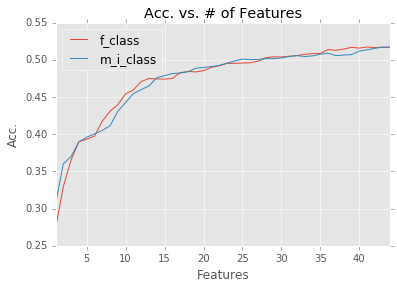

In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

sub_svc.plot()
plt.xlabel('Features')
plt.ylabel('Acc.')
plt.title('Acc. vs. # of Features')
plt.show()

In [17]:
print sub_svc.sort_values(by='f_class',ascending=False).head(1)
print sub_svc.sort_values(by='m_i_class',ascending=False).head(1)

     f_class  m_i_class
41  0.517155   0.513464
     f_class  m_i_class
44  0.516938   0.516938


Best performance of SVC with f_class, 41 features.

In [ ]:
sub_rfc = subsetc(RFC(n_estimators=300,max_depth=13,random_state=0),train,target1,n=3)

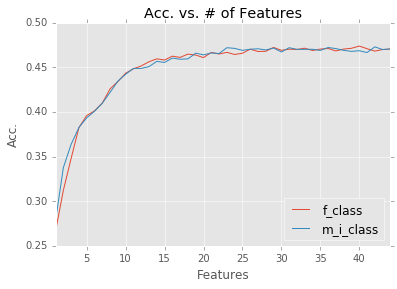

In [25]:
sub_rfc.plot()
plt.xlabel('Features')
plt.ylabel('Acc.')
plt.title('Acc. vs. # of Features')
plt.show()

In [26]:
print sub_rfc.sort_values(by='f_class',ascending=False).head(1)
print sub_rfc.sort_values(by='m_i_class',ascending=False).head(1)

     f_class  m_i_class
40  0.473724   0.468512
     f_class  m_i_class
42  0.468078   0.472856


In [55]:
clf_c = SelectKBest(f_classif,k=40)
clf_c.fit(train,target1)
cols = train.columns[clf_c.get_support(True)]

Best performance of RFC with f_class, 40 features.

Since both are pretty close, for simplicity sake will use 40 features on both, selected in the previous code.

In [56]:
rfc       = RFC(n_estimators=300,max_depth=13,random_state=0)
rfc.fit(train[cols],target1)
rfc_pred  = rfc.predict_proba(train[cols])
rfc_predc = rfc.predict(train[cols])

svc       = SVC(kernel='rbf',C=15.,gamma=0.005,probability=True)
svc.fit(train[cols],target1)
svc_pred  = svc.predict_proba(train[cols])
svc_predc = svc.predict(train[cols])

Check the performace of both algorithms, both the feature selection and the parameter tuning were done with crossvalidation, that should give us margin for generalization.

In [81]:
print 'SVC accuracy: {}'.format(sum(svc_predc==target1)/float(len(target1)))
print 'RFC accuracy: {}'.format(sum(rfc_predc==target1)/float(len(target1)))

SVC accuracy: 0.584780720799
RFC accuracy: 0.942466348241
